In [1]:
!pwd

/eos/home-i00/t/tmazuret/SWAN_projects/NMF_dials/notebooks


## Importing libraries

In [2]:
# Setting up DIALS object and importing dqmexplore
import sys
sys.path.append("../DQMExplore/src/")

from utils.setupdials import setup_dials_object_deviceauth
dials = setup_dials_object_deviceauth()

[2024-10-12 05:57:56,029] INFO: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-10-12 05:57:56,030] INFO: NumExpr defaulting to 8 threads.
[2024-10-12 05:57:56,746] INFO: This device will expire in 600 seconds.
[2024-10-12 05:57:56,748] INFO: Go to the following url and authenticate: https://auth.cern.ch/auth/realms/cern/device?user_code=CCJH-ESPK
[2024-10-12 05:57:56,748] INFO: Checking authorization status every 5 seconds...
[2024-10-12 05:58:02,105] INFO: Device authorized, authentication finished successfully!


In [3]:
# Importing DIALS objects
# For more information on DIALS, please visit https://github.com/cms-DQM/dials-py
from cmsdials.filters import LumisectionHistogram1DFilters, LumisectionHistogram2DFilters
from cmsdials.filters import OMSFilter, OMSPage

# All of the needed modules from DQMEplore (will be modified refactoring)
from dqmexplore.dataproc import trig_normalize
from dqmexplore.omsutils import get_rate
from dqmexplore.dataproc import generate_me_dict

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF

sys.path.append("../src/")
from datareco.data_reconstruction import DataReconstruction

## Loading MEs information from the DIALS

In [4]:
mes_list = dials.mes.list(LumisectionHistogram1DFilters())
df_me = pd.DataFrame(mes_list)
tracking_mes = df_me[df_me.iloc[:, 1].apply(lambda x: 'Tracking' in x[1])]

pd.set_option('display.max_colwidth', None)
tracking_mes.head(1)

,0,1,2,3
118,"(me_id, 10973340)","(me, Tracking/TrackParameters/generalTracks/GeneralProperties/Quality_GenTk)","(count, 483152)","(dim, 1)"


In [5]:
runnb = 383948
runnb_test = 384318
runnb_2 = 379765
runnb_test_2 = 380238
data1D = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb,
        dataset__regex = "ZeroBias",
        me = "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1"
    ),
    max_pages=200
).to_pandas()

data1D_test = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb_test,
        dataset__regex = "ZeroBias",
        me = "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1"
    ),
    max_pages=200
).to_pandas()

data1D_2 = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb_2,
        dataset__regex = "ZeroBias",
        me = "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1"
    ),
    max_pages=200
).to_pandas()

data1D_test_2 = dials.h1d.list_all(
    LumisectionHistogram1DFilters(
        run_number = runnb_test_2,
        dataset__regex = "ZeroBias",
        me = "PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1"
    ),
    max_pages=200
).to_pandas()

In [6]:
# Dictionaries out of the test and train data

# data1D_dict = generate_me_dict(data1D)
# data1D_dict_test = generate_me_dict(data1D_test)

# Keeping only 'data' after normalizing in the DataFrame

# trig_rate = get_rate(dials, runnb, "ZeroBias")
# # rtrn_np=True
# trig_rate_test = get_rate(dials, runnb_test, "ZeroBias")
# data1D_norm = trig_normalize(data1D_dict, trig_rate[:-2])
# data1D_norm_test = trig_normalize(data1D_dict_test, trig_rate_test)

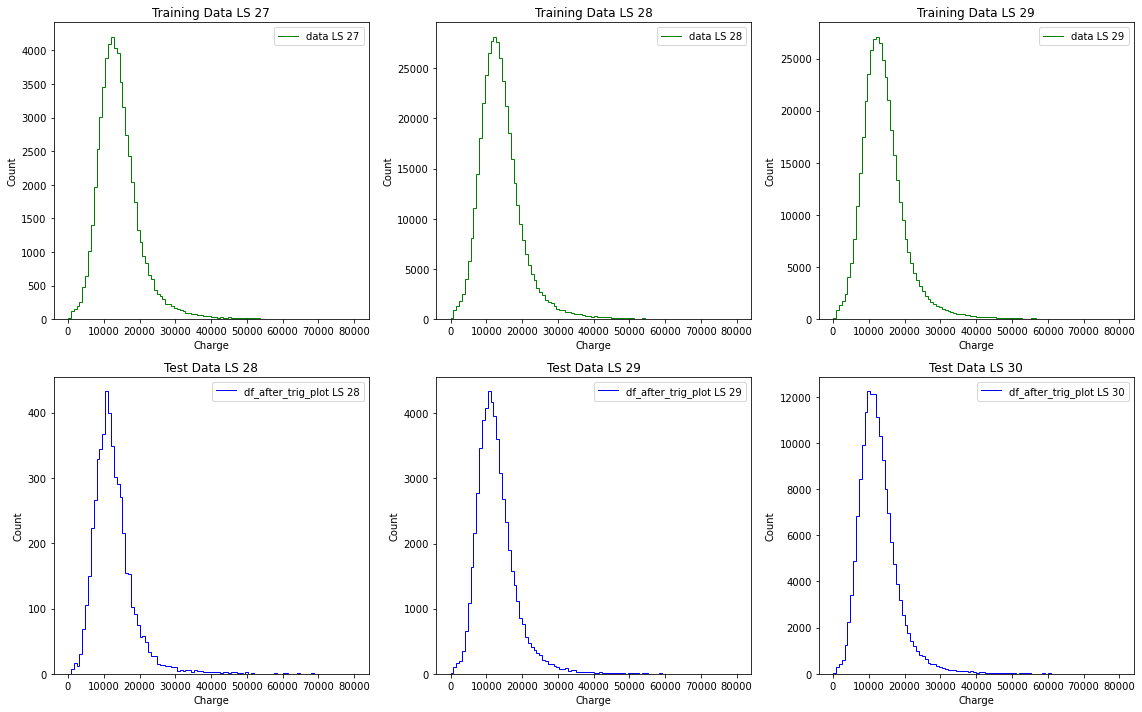

In [7]:
data = data1D['data'].iloc[27:30]  
data_test = data1D_test['data'].iloc[28:31]  

x_min = 0
x_max = 80000
x_bin = 100
bin_edges = np.linspace(x_min, x_max, x_bin + 1)

ls_number = data.index  
ls_number_test = data_test.index  

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot the first row: Training data
for i in range(3):
    axes[0, i].stairs(data.iloc[i], bin_edges, color='g', label=f'data LS {ls_number[i]}')
    axes[0, i].set_title(f'Training Data LS {ls_number[i]}')
    axes[0, i].set_xlabel('Charge')
    axes[0, i].set_ylabel('Count')
    axes[0, i].legend()

# Plot the second row: Test data
for i in range(3):
    axes[1, i].stairs(data_test.iloc[i], bin_edges, color='b', label=f'df_after_trig_plot LS {ls_number_test[i]}')
    axes[1, i].set_title(f'Test Data LS {ls_number_test[i]}')
    axes[1, i].set_xlabel('Charge')
    axes[1, i].set_ylabel('Count')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

In [8]:
# Function to normalize by the area under the curve
def normalize_by_area(series):
    total_sum = np.sum(series)  # Area under the curve
    if total_sum != 0:
        return np.round(series / total_sum, decimals=15)  
    else:
        return series

In [9]:
def contains_only_zeros_nan_or_inf(lst):
    return all(x == 0 for x in lst) or any(math.isnan(x) for x in lst) or any(math.isinf(x) for x in lst)

def filter_and_normalize(lst):
    if not contains_only_zeros_nan_or_inf(lst):
        return normalize_by_area(np.array(lst))
    else:
        return np.nan 
    
df_filtered = data1D.copy()
df_filtered['data_normalized'] = df_filtered['data'].apply(filter_and_normalize)
df_filtered = df_filtered.dropna(subset=['data_normalized'])[['data_normalized']]  

df_filtered_test = data1D_test.copy()
df_filtered_test['data_normalized'] = df_filtered_test['data'].apply(filter_and_normalize)
# df_filtered_test['data_normalized'] = df_filtered_test.apply(lambda x: filter_and_normalize(x["data"]), axis=1)
df_filtered_test = df_filtered_test.dropna(subset=['data_normalized'])[['data_normalized']] 

df_filtered_2 = data1D_2.copy()
df_filtered_2['data_normalized'] = df_filtered_2['data'].apply(filter_and_normalize)
df_filtered_2 = df_filtered_2.dropna(subset=['data_normalized'])[['data_normalized']] 

df_filtered_test_2 = data1D_test_2.copy()
df_filtered_test_2['data_normalized'] = df_filtered_test_2['data'].apply(filter_and_normalize)
df_filtered_test_2 = df_filtered_test_2.dropna(subset=['data_normalized'])[['data_normalized']] 

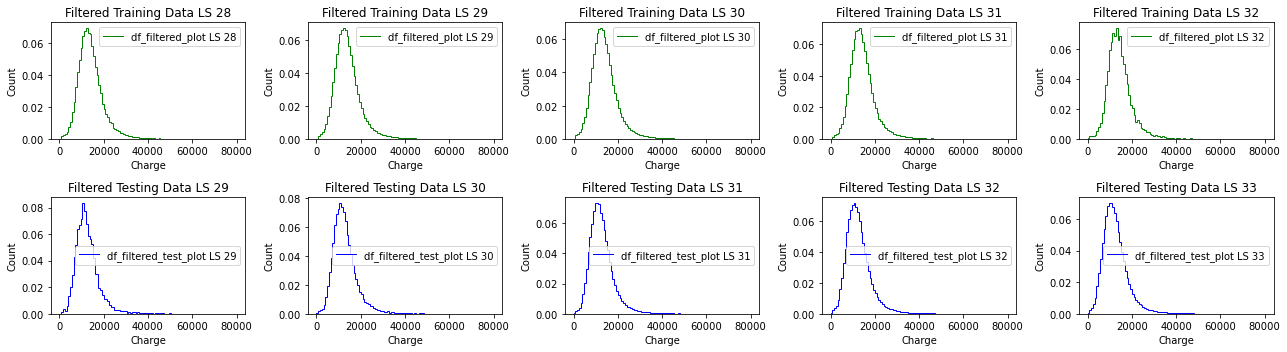

In [11]:
df_filtered_plot = df_filtered['data_normalized'].iloc[:5]
df_filtered_test_plot = df_filtered_test['data_normalized'].iloc[:5]

ls_number = df_filtered_plot.index 
ls_number_test = df_filtered_test_plot.index 

fig, axes = plt.subplots(2, 5, figsize=(18, 5))

# Training Data
for i in range(5):
    axes[0, i].stairs(df_filtered_plot.iloc[i], bin_edges, color='g', label=f'df_filtered_plot LS {ls_number[i]+1}')
    
    axes[0, i].set_title(f'Filtered Training Data LS {ls_number[i]+1}')
    axes[0, i].set_xlabel('Charge')
    axes[0, i].set_ylabel('Count')
    axes[0, i].legend()

# Test Data
for i in range(5):
    axes[1, i].stairs(df_filtered_test_plot.iloc[i], bin_edges, color='b', label=f'df_filtered_test_plot LS {ls_number_test[i]+1}')
    
    axes[1, i].set_title(f'Filtered Testing Data LS {ls_number_test[i]+1}')
    axes[1, i].set_xlabel('Charge')
    axes[1, i].set_ylabel('Count')
    axes[1, i].legend()
    
plt.tight_layout()
plt.show()

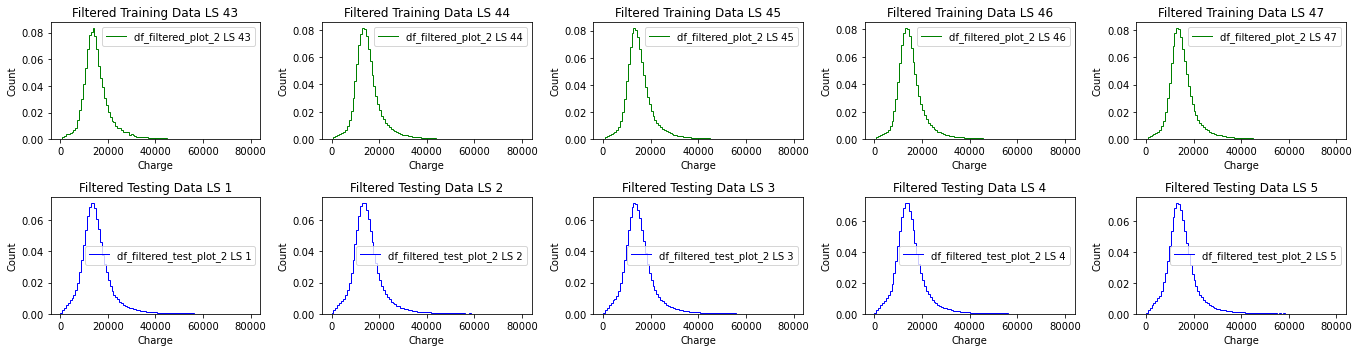

In [12]:
df_filtered_plot_2 = df_filtered_2['data_normalized'].iloc[:5]
df_filtered_test_plot_2 = df_filtered_test_2['data_normalized'].iloc[:5]

ls_number_2 = df_filtered_plot_2.index 
ls_number_test_2 = df_filtered_test_plot_2.index 

fig, axes = plt.subplots(2, 5, figsize=(19, 5))

# Training Data
for i in range(5):
    axes[0, i].stairs(df_filtered_plot_2.iloc[i], bin_edges, color='g', label=f'df_filtered_plot_2 LS {ls_number_2[i]+1}')
    
    axes[0, i].set_title(f'Filtered Training Data LS {ls_number_2[i]+1}')
    axes[0, i].set_xlabel('Charge')
    axes[0, i].set_ylabel('Count')
    axes[0, i].legend()

# Test Data
for i in range(5):
    axes[1, i].stairs(df_filtered_test_plot_2.iloc[i], bin_edges, color='b', label=f'df_filtered_test_plot_2 LS {ls_number_test_2[i]+1}')
    
    axes[1, i].set_title(f'Filtered Testing Data LS {ls_number_test_2[i]+1}')
    axes[1, i].set_xlabel('Charge')
    axes[1, i].set_ylabel('Count')
    axes[1, i].legend()
    
plt.tight_layout()
plt.show()

In [13]:
data_lists = df_filtered['data_normalized'].tolist()
data_lists_test = df_filtered_test['data_normalized'].tolist()

dense_matrix = np.array(data_lists)
dense_matrix_test = np.array(data_lists_test)

data_lists_2 = df_filtered_2['data_normalized'].tolist()
data_lists_test_2 = df_filtered_test_2['data_normalized'].tolist()

dense_matrix_2 = np.array(data_lists_2)
dense_matrix_test_2 = np.array(data_lists_test_2)

In [14]:
model = NMF(n_components= 7, random_state=1, init= "random", verbose = True)
W = model.fit_transform(dense_matrix)
H = model.components_

# Reconstructed trained data
reconstructed_matrix_train = np.dot(W, H)

# Transformation of the test data
W_test = model.transform(dense_matrix_test)

# Reconstruction of the test data
reconstructed_matrix_test = np.dot(W_test, H)

print("\nW (Coefficient Matrix for Training Data):")
print(W)

print("\nH (Basis Matrix for Training Data):")
print(H)

print("\nReconstructed Training Matrix:")
print(reconstructed_matrix_train)

print("\nOriginal Test Matrix (Dense):")
print(dense_matrix_test)

print("\nW_test (Coefficient Matrix for Test Data):")
print(W_test)

print("\nReconstructed Test Matrix:")
print(reconstructed_matrix_test)

violation: 1.0
violation: 0.1719609257943542
violation: 0.020987846399192458
violation: 0.019285100194879837
violation: 0.01779619981094987
violation: 0.013567140506932574
violation: 0.009018544047178768
violation: 0.00598523650250036
violation: 0.004385507304500426
violation: 0.0035109634111480364
violation: 0.0029454855328663646
violation: 0.0025225809822511575
violation: 0.0021773688476771033
violation: 0.0019090364680417582
violation: 0.0016968589204567792
violation: 0.0015196793519544308
violation: 0.0013668762749240357
violation: 0.0012396906176749805
violation: 0.0011340420043565275
violation: 0.001041232801663844
violation: 0.000965308433728333
violation: 0.0008969770828710576
violation: 0.0008379514589403793
violation: 0.0007861978787898981
violation: 0.0007407073027705798
violation: 0.0007001264152993815
violation: 0.0006662136130770943
violation: 0.0006378214289550517
violation: 0.0006135588699613284
violation: 0.0005920490397614327
violation: 0.000572861051433001
violation:

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [15]:
model_2 = NMF(n_components=6, random_state=1, init="random", verbose=True)
W_2 = model_2.fit_transform(dense_matrix_2)
H_2 = model_2.components_

# Reconstructed trained data (Model 2)
reconstructed_matrix_train_2 = np.dot(W_2, H_2)

# Transformation of the test data (Model 2)
W_test_2 = model_2.transform(dense_matrix_test_2)

# Reconstruction of the test data (Model 2)
reconstructed_matrix_test_2 = np.dot(W_test_2, H_2)

# Output for Model 2
print("\nW (Coefficient Matrix for Training Data) - Model 2:")
print(W_2)

print("\nH (Basis Matrix for Training Data) - Model 2:")
print(H_2)

print("\nReconstructed Training Matrix - Model 2:")
print(reconstructed_matrix_train_2)

print("\nOriginal Test Matrix (Dense) - Model 2:")
print(dense_matrix_test_2)

print("\nW_test (Coefficient Matrix for Test Data) - Model 2:")
print(W_test_2)

print("\nReconstructed Test Matrix - Model 2:")
print(reconstructed_matrix_test_2)

violation: 1.0
violation: 0.28455992205752045
violation: 0.022253532971742058
violation: 0.012654683411855999
violation: 0.013464171198762486
violation: 0.014153447202952443
violation: 0.013585251059236601
violation: 0.012289481156601454
violation: 0.010638324564933849
violation: 0.00911582840909501
violation: 0.007732190671962652
violation: 0.006595219963834406
violation: 0.005736160724128699
violation: 0.005074442794298721
violation: 0.0045692120870768045
violation: 0.004202815343410395
violation: 0.003949008955342122
violation: 0.0037983479494011563
violation: 0.0037018578587730533
violation: 0.0036644095999865847
violation: 0.0036354801933693604
violation: 0.0036395249353390435
violation: 0.0036422378972280666
violation: 0.003635409787937945
violation: 0.00363383374536133
violation: 0.0036222671088634523
violation: 0.003598464123103055
violation: 0.003566121652950227
violation: 0.0035125408161807213
violation: 0.003482318964626948
violation: 0.003448622372950301
violation: 0.003412

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


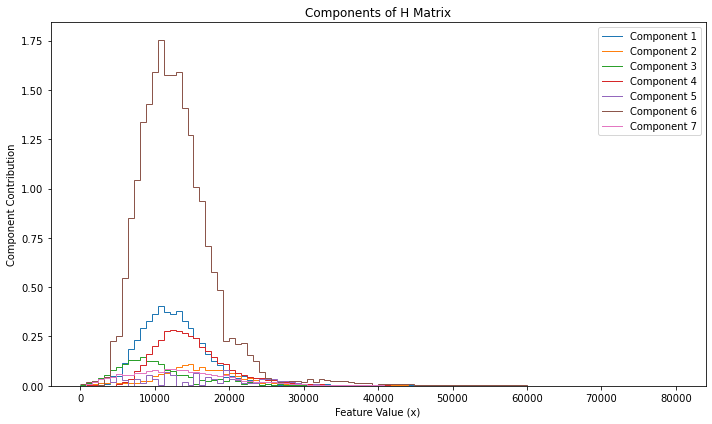

In [16]:
reconstruction_1 = DataReconstruction(W=W, H=H, dense_matrix=dense_matrix, W_test=W_test, dense_matrix_test=dense_matrix_test, model_name="Model 1")
reconstruction_1.plot_all_components(variable_name='H')


--- Model 1 Component Contributions (Train) ---
Model 1 Component 1 (train) - Area Contribution: 59.53%, W Contribution: 32.97%, W Coefficient: 0.118478
Model 1 Component 2 (train) - Area Contribution: 21.89%, W Contribution: 38.17%, W Coefficient: 0.137147
Model 1 Component 3 (train) - Area Contribution: 0.28%, W Contribution: 0.42%, W Coefficient: 0.001517
Model 1 Component 4 (train) - Area Contribution: 8.29%, W Contribution: 6.15%, W Coefficient: 0.022116
Model 1 Component 5 (train) - Area Contribution: 8.15%, W Contribution: 21.25%, W Coefficient: 0.076375
Model 1 Component 6 (train) - Area Contribution: 1.32%, W Contribution: 0.17%, W Coefficient: 0.000598
Model 1 Component 7 (train) - Area Contribution: 0.55%, W Contribution: 0.87%, W Coefficient: 0.003110

--- Model 1 Component Contributions (Test) ---
Model 1 Component 1 (test) - Area Contribution: 77.80%, W Contribution: 53.46%, W Coefficient: 0.158671
Model 1 Component 2 (test) - Area Contribution: 0.00%, W Contribution: 0.

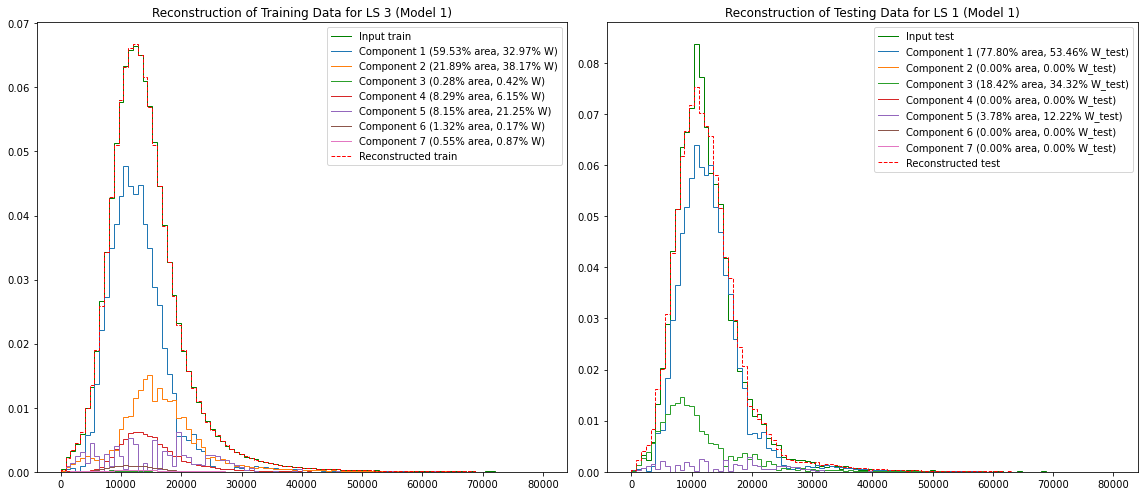

In [36]:
reconstruction_1.plot_reconstruction(ls_train=2, ls_test=0)

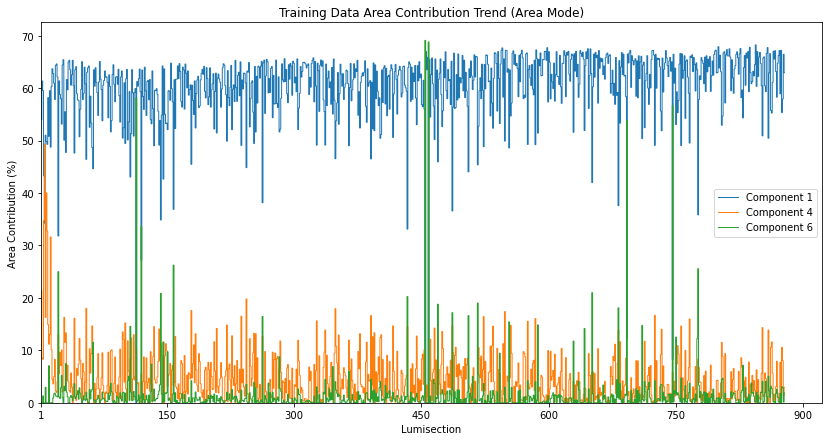

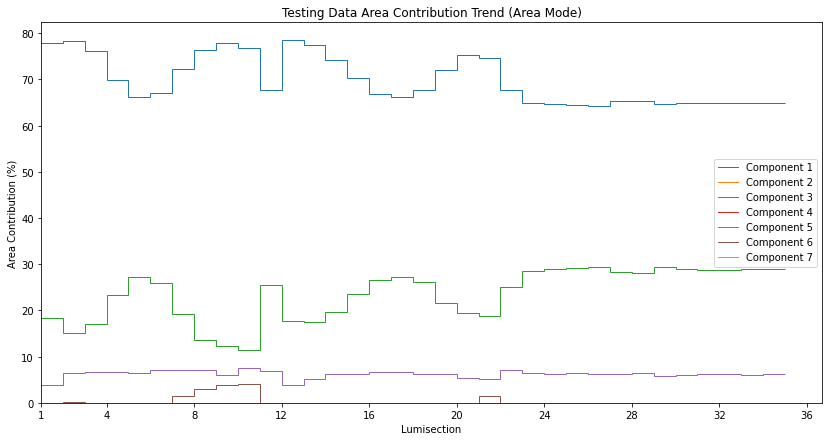

In [18]:
df_train_contributions_area = reconstruction_1.collect_contributions(
    W=reconstruction_1.W, 
    H=reconstruction_1.H, 
    dense_matrix=reconstruction_1.dense_matrix, 
    num_ls="all", 
    mode="area"
)

df_test_contributions_area = reconstruction_1.collect_contributions(
    W=reconstruction_1.W_test, 
    H=reconstruction_1.H, 
    dense_matrix=reconstruction_1.dense_matrix_test, 
    num_ls="all", 
    mode="area"
)

reconstruction_1.plot_trend(df=df_train_contributions_area, title="Training Data Area Contribution Trend", components=[1, 4, 6], mode="area")

reconstruction_1.plot_trend(df=df_test_contributions_area, title="Testing Data Area Contribution Trend", components="all", mode="area")

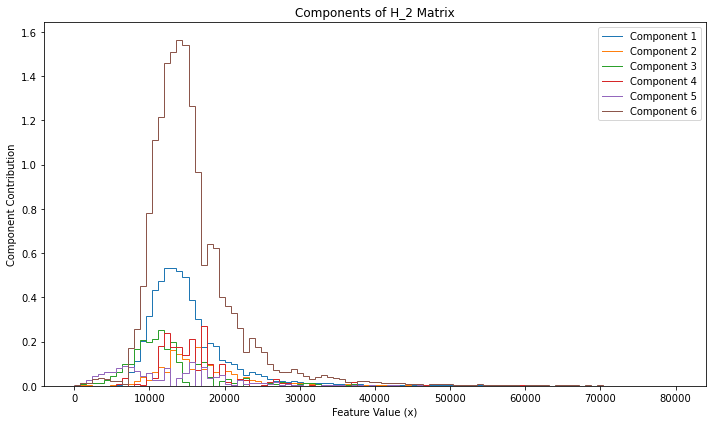

In [19]:
reconstruction_2 = DataReconstruction(W=W_2, H=H_2, dense_matrix=dense_matrix_2, W_test=W_test_2, dense_matrix_test=dense_matrix_test_2, model_name="Model 2")
reconstruction_2.plot_all_components(variable_name='H_2')


--- Model 2 Component Contributions (Train) ---
Model 2 Component 1 (train) - Area Contribution: 56.41%, W Contribution: 27.21%, W Coefficient: 0.096982
Model 2 Component 2 (train) - Area Contribution: 22.12%, W Contribution: 37.23%, W Coefficient: 0.132693
Model 2 Component 3 (train) - Area Contribution: 0.88%, W Contribution: 1.05%, W Coefficient: 0.003731
Model 2 Component 4 (train) - Area Contribution: 9.53%, W Contribution: 13.16%, W Coefficient: 0.046899
Model 2 Component 5 (train) - Area Contribution: 10.59%, W Contribution: 21.28%, W Coefficient: 0.075847
Model 2 Component 6 (train) - Area Contribution: 0.47%, W Contribution: 0.08%, W Coefficient: 0.000270

--- Model 2 Component Contributions (Test) ---
Model 2 Component 1 (test) - Area Contribution: 43.51%, W Contribution: 17.73%, W Coefficient: 0.074587
Model 2 Component 2 (test) - Area Contribution: 26.68%, W Contribution: 37.94%, W Coefficient: 0.159608
Model 2 Component 3 (test) - Area Contribution: 6.16%, W Contribution:

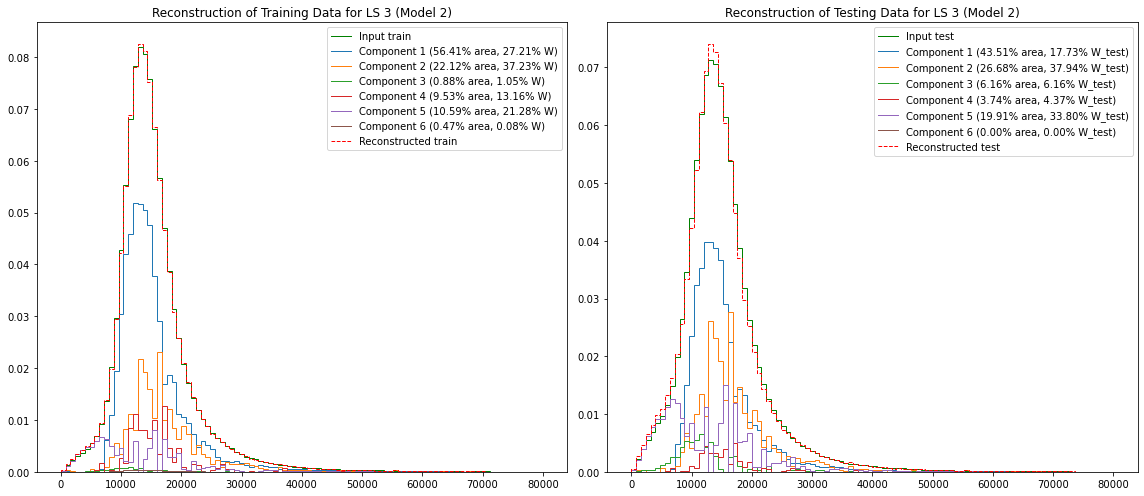

In [20]:
reconstruction_2.plot_reconstruction(ls_train=2, ls_test=2)

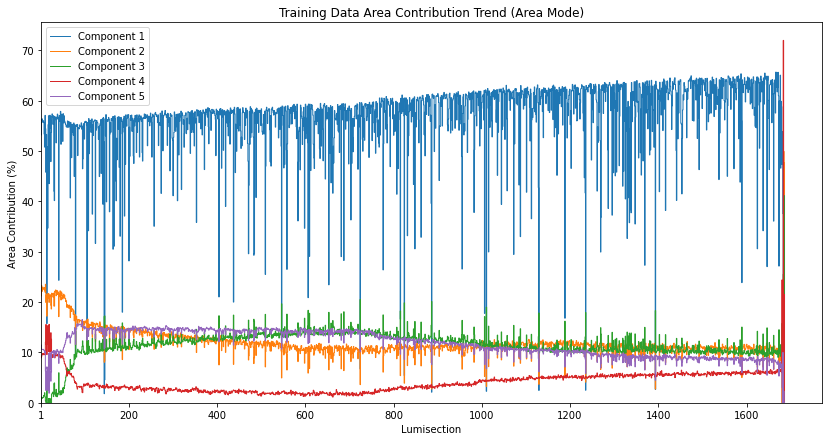

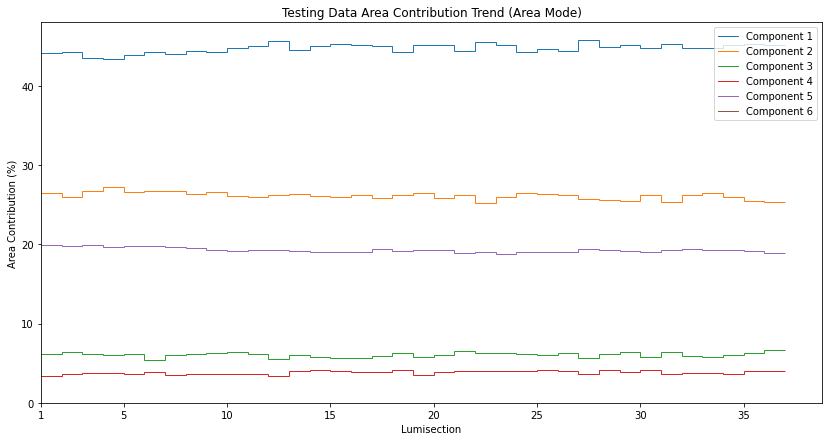

In [30]:
df_train_contributions_area_2 = reconstruction_2.collect_contributions(
    W=reconstruction_2.W, 
    H=reconstruction_2.H, 
    dense_matrix=reconstruction_2.dense_matrix, 
    num_ls="all", 
    mode="area"
)

df_test_contributions_area_2 = reconstruction_2.collect_contributions(
    W=reconstruction_2.W_test, 
    H=reconstruction_2.H, 
    dense_matrix=reconstruction_2.dense_matrix_test, 
    num_ls="all", 
    mode="area"
)

reconstruction_2.plot_trend(df=df_train_contributions_area_2, title="Training Data Area Contribution Trend", components= [1, 2, 3, 4, 5], mode="area")

reconstruction_2.plot_trend(df=df_test_contributions_area_2, title="Testing Data Area Contribution Trend", components="all", mode="area")

In [23]:
from sklearn.metrics import mean_squared_error

# Calculate error for training data
train_error = mean_squared_error(dense_matrix, reconstructed_matrix_train)

# Calculate error for test data
test_error = mean_squared_error(dense_matrix_test, reconstructed_matrix_test)

print(f'Training Error: {train_error}')
print(f'Test Error: {test_error}')

Training Error: 1.891210803982121e-08
Test Error: 7.837284763476887e-07


$$
X_{\text{scaled}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}
$$

<table>
  <tr>
    <td>$$ X $$</td>
    <td>- the original feature value for a particular component</td>
  </tr>
  <tr>
    <td>$$ X_{\text{min}} $$</td>
    <td>- the minimum value of that component in the dataset</td>
  </tr>
  <tr>
    <td>$$ X_{\text{max}} $$</td>
    <td>- the maximum value of that component in the dataset</td>
  </tr>
  <tr>
    <td>$$ X_{\text{scaled}} $$</td>
    <td>- the normalized value of X in the range [0,1]</td>
  </tr>
</table>



In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

# Fit and transform training data
W_scaled = scaler_train.fit_transform(W)
W_scaled = np.round(W_scaled, decimals=6)

# Fit and transform test data separately
W_test_scaled = scaler_test.fit_transform(W_test)
W_test_scaled = np.round(W_test_scaled, decimals=6)

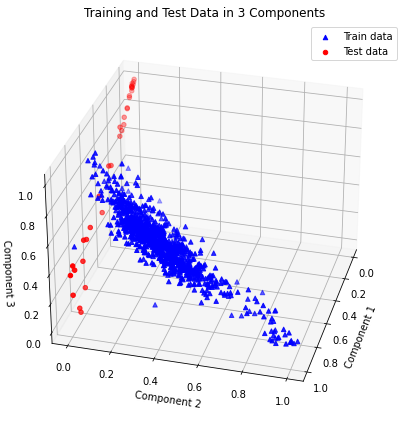

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(W_scaled[:, 0], W_scaled[:, 1], W_scaled[:, 2], c='blue', marker='^', label='Train data')
ax.scatter(W_test_scaled[:, 0], W_test_scaled[:, 1], W_test_scaled[:, 2], c='red', marker='o', label='Test data')

#ax.scatter(W_test_scaled[:, 0], W_test_scaled[:, 1], W_test_scaled[:, 2], c='red', marker='o', label='Test data')

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

ax.set_title('Training and Test Data in 3 Components')

ax.legend()

ax.view_init(elev=30, azim=15)

plt.tight_layout()
plt.show()

In [26]:
df_reco_1 = pd.DataFrame(reconstructed_matrix_train)
data1D_reco = pd.DataFrame({'data': df_reco_1.values.tolist()})
df_reco_1_test = pd.DataFrame(reconstructed_matrix_test)
data1D_reco_test = pd.DataFrame({'data': df_reco_1_test.values.tolist()})